Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Computed Class Weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}
Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.5199 - loss: 0.7154 - val_accuracy: 0.5625 - val_loss: 0.6718 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.5851 - loss: 0.6604 - val_accuracy: 0.5625 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.6582 - loss: 0.6384 - val_accuracy: 0.5625 - val_loss: 0.6489 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.6929 - loss: 0.6129 - val_accuracy: 0.5625 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.7034 - loss: 0.6010 - val_accuracy: 0.7500 - val_loss: 0.6121 - learning_rate: 0.0010
Epoch 6/15
163/16

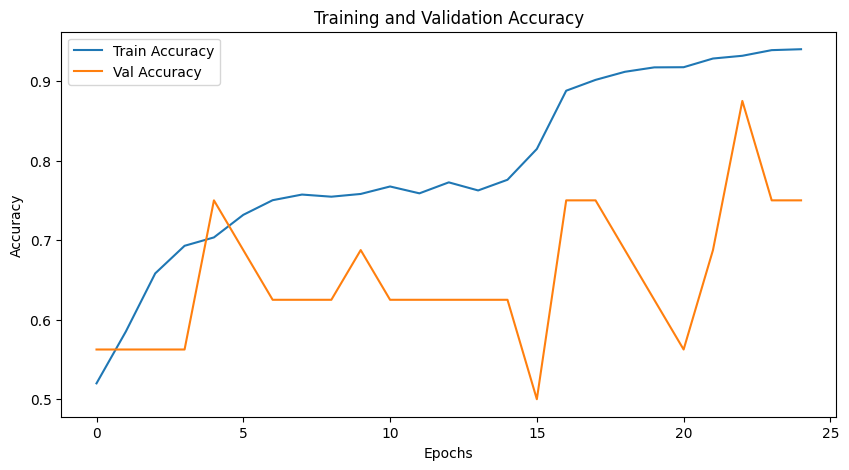

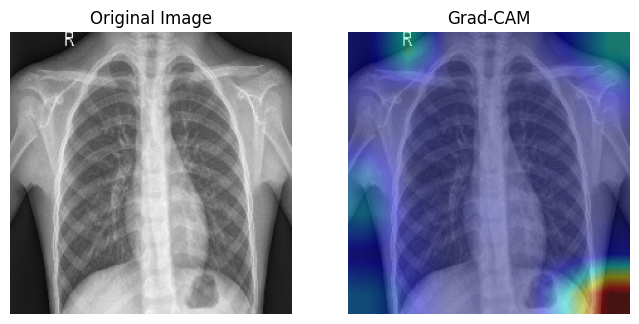

: 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

# =========================
# DATA DIRECTORIES
# =========================
train_dir = '../data/train'
test_dir = '../data/test'
val_dir = '../data/val'

# =========================
# DATA AUGMENTATION
# =========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# =========================
# DATA LOADERS
# =========================
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary'
)

# =========================
# CLASS WEIGHTS
# =========================
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Computed Class Weights:", class_weights)

# =========================
# BASE MODEL (ResNet50)
# =========================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# =========================
# CALLBACKS
# =========================
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# =========================
# INITIAL TRAINING
# =========================
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights,
    callbacks=[lr_scheduler, early_stop]
)

# =========================
# FINE-TUNING
# =========================
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights,
    callbacks=[lr_scheduler, early_stop]
)

# =========================
# EVALUATE ON TEST DATA
# =========================
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# =========================
# PLOT TRAINING CURVES
# =========================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# =========================
# GRAD-CAM VISUALIZATION
# =========================
def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Pick a random test image for visualization
sample_img_path = test_generator.filepaths[0]  # take first test image
img = load_img(sample_img_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Generate Grad-CAM
last_conv_layer_name = [layer.name for layer in model.layers if 'conv5_block3_out' in layer.name][0]
heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Superimpose on original image
img_orig = cv2.imread(sample_img_path)
img_orig = cv2.resize(img_orig, (224, 224))
heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()
